# Predicting the Unemployment Rate using Machine Learning Models 
- Regression
- ML models used
 - LightGBM
 - XGBoost
 - Linear Regression
 - Random Forest Regressor (Ensemble)

# Import relevant libraries

In [179]:
# Data Analysis and tools
import pandas as pd
import numpy as np
import joblib

# Visualisation
import matplotlib.pyplot as plt


# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from mlforecast import MLForecast
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from window_ops.expanding import expanding_mean

## Extract data from source
- Using the dataset that was extracted from OECD Inflation (CPI)

In [159]:
# Read data from direct link (OECD)
raw_data = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CPI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")

In [160]:
# Snapshot of data
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292851 entries, 0 to 292850
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   LOCATION    292851 non-null  object 
 1   INDICATOR   292851 non-null  object 
 2   SUBJECT     292851 non-null  object 
 3   MEASURE     292851 non-null  object 
 4   FREQUENCY   292851 non-null  object 
 5   TIME        292851 non-null  object 
 6   Value       292851 non-null  float64
 7   Flag Codes  51 non-null      object 
dtypes: float64(1), object(7)
memory usage: 17.9+ MB


## Data Preprocessing
- Mainly preprocessing steps to parse datetime column, filter to appropriate measure, filling missing rows with ffill/bfill to ensure all time series have complete/same start and end date, and transform into the right shape

In [161]:
panel_data = (
    raw_data
    # Rename location to country and all columns to lowercase 
    .rename(columns=str.lower)
    .rename(columns={"location": "country"})
    # Filter by measure = AGRWTH (average growth rate), TOT (total) as subject, and monthly frequency only
    .pipe(
        lambda df: df.loc[(df["measure"] == "AGRWTH") & (df["frequency"] == "M") & (df["subject"] == "TOT")]
    )
    # Parse datetime column (time) to YY-MM-DD format
    .assign(time=lambda df: pd.to_datetime(df["time"]))
    # Set index to time and sort by ascending
    .set_index("time")
    .sort_index()
    # Forward fill missing values
    .ffill()
    .pivot(columns=["country"], values="value")
    # Backward and forward fill missing values to make complete time series for each countries
    .bfill()
    .ffill()
    # Stack the country column
    .stack("country")
    # Rename series to cpi
    .rename("cpi")
    # Rearrange and sort index
    .reset_index()
    .set_index(["country", "time"])
    .sort_index()
)

In [162]:
# Snapshot of data
panel_data.info()
panel_data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 63847 entries, ('ARG', Timestamp('1915-01-01 00:00:00')) to ('ZAF', Timestamp('2023-07-01 00:00:00'))
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cpi     63847 non-null  float64
dtypes: float64(1)
memory usage: 729.9+ KB


cpi
country time                 
ARG     1915-01-01  24.795600
        1915-02-01  24.795600
        1915-03-01  24.795600
        1915-04-01  24.795600
        1915-05-01  24.795600
...                       ...
ZAF     2023-03-01   7.262022
        2023-04-01   7.121951
        2023-05-01   6.589147
        2023-06-01   5.656759
        2023-07-01   5.656759

[63847 rows x 1 columns]

## Split data to individual time series

In [163]:
TEST_SIZE = 7
N_SPLITS = 5 # Default number of splits

In [164]:
# Define the TimeSeriesSplit from sklearn
tscv = TimeSeriesSplit(n_splits=N_SPLITS, test_size=TEST_SIZE)

In [165]:
ts_splits_by_country = panel_data.groupby("country").apply(
    lambda x: list(tscv.split(x))
)

In [166]:
# Splitting the time series data by index and return a dictionary of n_splits: array(test/train)
train_by_splits = {}
test_by_splits = {}
for i, ts_split in enumerate(ts_splits_by_country):
    # Filter y data by the index from the ts_split
    y = panel_data[panel_data.index.get_level_values(0)==ts_splits_by_country.index[i]]
    for n_split, (train_index, test_index) in enumerate(ts_split):
        # Split based on train/test 
        train_dataset = y.iloc[train_index]
        test_dataset = y.iloc[test_index]
        if n_split not in train_by_splits.keys():
            train_by_splits[n_split] = []
            test_by_splits[n_split] = []
        
        # Append train and test dataset to the defined dictionary
        train_by_splits[n_split].append(train_dataset)
        test_by_splits[n_split].append(test_dataset)
        
# Concatenate the list of dataframes for train and test datasets by each split
for n_split in range(N_SPLITS):
    train_by_splits[n_split] = pd.concat(train_by_splits[n_split])
    test_by_splits[n_split] = pd.concat(test_by_splits[n_split])

In [167]:
# Snapshot of the splits
# Check if both train and test set has same number of split as N_SPLITS = 5
print(f"Number of splits for train set: {len(train_by_split.keys())}")
print(f"Number of splits for test set: {len(train_by_split.keys())}")

# Check if all the countries/entity_col is similar
print(f"Number of countries in the dataset: {ts_splits_by_country.index.nunique()}")
print(f"Number of countries (train dataset) for the first split: {train_by_split[0].index.levels[0].nunique()}")
print(f"Number of countries for (test dataset) for the first split: {test_by_split[0].index.levels[0].nunique()}")

Number of splits for train set: 5
Number of splits for test set: 5
Number of countries in the dataset: 49
Number of countries (train dataset) for the first split: 49
Number of countries for (test dataset) for the first split: 49


## Machine Learning 

### Backtesting the ML Models

In [168]:
SELECTED_MODELS = [
    LinearRegression(),
    RandomForestRegressor(random_state=28),
    lgb.LGBMRegressor(),
    xgb.XGBRegressor(),
]



In [169]:
backtests = []
for n in range(N_SPLITS):
    train = train_by_splits[n].reset_index()
    # Assign the model for forecasting
    backtest_model = MLForecast(
        models=SELECTED_MODELS,
        freq="MS",
        lags=[1, 12],
        lag_transforms={
            1: [expanding_mean],
        },
        # Based on local machine
        num_threads=12,
    )

    # Fit the backtest model with the appropriate feature names
    backtest_model.fit(train, id_col="country", time_col="time", target_col="cpi")

    # Backtest the model
    backtest = backtest_model.predict(TEST_SIZE)
    backtests.append(backtest)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 61544, number of used features: 3
[LightGBM] [Info] Start training from score 52.848349
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 61887, number of used features: 3
[LightGBM] [Info] Start training from score 52.568441
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] T

In [170]:
backtest = (
    pd.concat(backtests).set_index(["country", "time"])
    # The ensemble value would be the mean of all the 4 models
    .assign(Ensemble=lambda df: df.mean(axis=1))
    # Round the values to 2 d.p.
    .round(2)
)
backtest

LinearRegression  RandomForestRegressor  LGBMRegressor  \
country time                                                                 
ARG     2020-09-01             40.16                  40.78          44.22   
        2020-10-01             39.70                  40.91          44.22   
        2020-11-01             39.21                  40.55          44.22   
        2020-12-01             38.71                  40.90          44.22   
        2021-01-01             38.21                  40.67          44.22   
...                              ...                    ...            ...   
ZAF     2023-03-01              7.59                   7.67           7.43   
        2023-04-01              7.62                   7.61           7.43   
        2023-05-01              7.64                   7.79           7.43   
        2023-06-01              7.64                   7.81           7.41   
        2023-07-01              7.64                   7.93           7.40   

                    XGBRegressor  Ensemble  
country time                                
ARG     2020-09-01     40.599998     41.44  
        2020-10-01     41.240002     41.52  
        2020-11-01     41.660000     41.41  
        2020-12-01     40.599998     41.11  
        2021-01-01     40.980000     41.02  
...                          ...       ...  
ZAF     2023-03-01      7.470000      7.54  
        2023-04-01      7.470000      7.53  
        2023-05-01      7.470000      7.58  
        2023-06-01      7.490000      7.59  
        2023-07-01      7.370000      7.59  

[1715 rows x 5 columns]

## Forecasting

In [171]:
# Assign the model for forecasting
forecast_model = MLForecast(
    models=SELECTED_MODELS,
    freq="MS",
    lags=[1, 12],
    lag_transforms={
        1: [expanding_mean],
    },
    num_threads=12,
)

# Fitting
forecast_model.fit(panel_data.reset_index(), id_col="country", time_col="time", target_col="cpi")

# Predict for backtest
forecast = (
    # Predict for 12 months ahead
    forecast_model.predict(12)
    .set_index(["country", "time"])
    # The ensemble value would be the mean of all the 4 models
    .assign(Ensemble=lambda df: df.mean(axis=1))
    # Round the values to 2 d.p.
    .round(2)
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 63259, number of used features: 3
[LightGBM] [Info] Start training from score 51.625923


In [172]:
forecast

LinearRegression  RandomForestRegressor  LGBMRegressor  \
country time                                                                 
ARG     2023-08-01            114.54                 115.78         121.35   
        2023-09-01            113.43                 115.94         121.35   
        2023-10-01            112.26                 116.59         121.35   
        2023-11-01            111.03                 116.73         127.76   
        2023-12-01            109.77                 117.47         127.76   
...                              ...                    ...            ...   
ZAF     2024-03-01              5.72                   5.80           5.63   
        2024-04-01              5.73                   5.85           5.64   
        2024-05-01              5.75                   5.73           5.64   
        2024-06-01              5.78                   5.71           5.64   
        2024-07-01              5.82                   5.60           5.64   

                    XGBRegressor  Ensemble  
country time                                
ARG     2023-08-01    115.220001    116.72  
        2023-09-01    115.220001    116.49  
        2023-10-01    115.220001    116.36  
        2023-11-01    115.220001    117.69  
        2023-12-01    115.220001    117.55  
...                          ...       ...  
ZAF     2024-03-01      5.940000      5.77  
        2024-04-01      5.940000      5.79  
        2024-05-01      5.950000      5.77  
        2024-06-01      5.950000      5.77  
        2024-07-01      5.950000      5.75  

[588 rows x 5 columns]

# Compute Scores for the models

In [174]:
dates = backtest.index.get_level_values(1).unique()
dates

DatetimeIndex(['2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01'],
              dtype='datetime64[ns]', name='time', freq=None)

In [175]:
actual_data = panel_data[panel_data.index.get_level_values(1).isin(dates)]
actual_data

cpi
country time                 
ARG     2020-09-01  36.620720
        2020-10-01  37.239040
        2020-11-01  35.797820
        2020-12-01  36.140590
        2021-01-01  38.531980
...                       ...
ZAF     2023-03-01   7.262022
        2023-04-01   7.121951
        2023-05-01   6.589147
        2023-06-01   5.656759
        2023-07-01   5.656759

[1715 rows x 1 columns]

In [177]:
comparison_df = actual_data.join(backtest)
comparison_df

cpi  LinearRegression  RandomForestRegressor  \
country time                                                             
ARG     2020-09-01  36.620720             40.16                  40.78   
        2020-10-01  37.239040             39.70                  40.91   
        2020-11-01  35.797820             39.21                  40.55   
        2020-12-01  36.140590             38.71                  40.90   
        2021-01-01  38.531980             38.21                  40.67   
...                       ...               ...                    ...   
ZAF     2023-03-01   7.262022              7.59                   7.67   
        2023-04-01   7.121951              7.62                   7.61   
        2023-05-01   6.589147              7.64                   7.79   
        2023-06-01   5.656759              7.64                   7.81   
        2023-07-01   5.656759              7.64                   7.93   

                    LGBMRegressor  XGBRegressor  Ensemble  
country time                                               
ARG     2020-09-01          44.22     40.599998     41.44  
        2020-10-01          44.22     41.240002     41.52  
        2020-11-01          44.22     41.660000     41.41  
        2020-12-01          44.22     40.599998     41.11  
        2021-01-01          44.22     40.980000     41.02  
...                           ...           ...       ...  
ZAF     2023-03-01           7.43      7.470000      7.54  
        2023-04-01           7.43      7.470000      7.53  
        2023-05-01           7.43      7.470000      7.58  
        2023-06-01           7.41      7.490000      7.59  
        2023-07-01           7.40      7.370000      7.59  

[1715 rows x 6 columns]

## Compute Metrics

In [202]:
def compute_score(row, col_name, metric):
    return metric(row["cpi"], row[col_name])

In [203]:
metrics = {
    "mse": mean_squared_error, 
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error
}

In [204]:
scores = (
    comparison_df
    .groupby("country", group_keys=True)
    .agg(list)
    # Compute scores
    .pipe(
        lambda df: df.assign(
            **{
                f"{col}_{metric_name}": df.apply(lambda s: compute_score(s, col, metric), axis=1)
                for col in df.columns if col != "cpi"
                for metric_name, metric in metrics.items()
            }
        )
    )
    .filter(regex="_mae|_mape|_mse")
)
scores

,LinearRegression_mse,LinearRegression_mae,LinearRegression_mape,RandomForestRegressor_mse,RandomForestRegressor_mae,RandomForestRegressor_mape,LGBMRegressor_mse,LGBMRegressor_mae,LGBMRegressor_mape,XGBRegressor_mse,XGBRegressor_mae,XGBRegressor_mape,Ensemble_mse,Ensemble_mae,Ensemble_mape
country,,,,,,,,,,,,,,,
ARG,225.510223,11.100324,1.478695e-01,100.621086,8.038680,1.190893e-01,145.323733,9.399498,1.329445e-01,240.184960,11.567252,1.514206e-01,168.219224,9.909537,1.353059e-01
AUT,2.651984,1.288318,2.468992e-01,3.847456,1.529372,2.557876e-01,2.895220,1.351461,2.468452e-01,2.392637,1.178626,2.035446e-01,2.859119,1.316092,2.252234e-01
BEL,7.271892,2.113400,6.174652e-01,6.683741,1.954497,6.483669e-01,7.954471,2.093670,4.966147e-01,7.428889,1.981591,5.188361e-01,7.259260,2.027400,5.683473e-01
BRA,108.695535,9.066539,1.519348e+00,9.290130,2.354024,3.722632e-01,113.428641,6.248395,1.000158e+00,99.787782,7.094312,1.039656e+00,55.491877,4.743367,7.688916e-01
CAN,2.206321,1.187531,3.635502e-01,3.284484,1.428960,4.370650e-01,2.715440,1.352102,4.158087e-01,2.706626,1.344079,4.563752e-01,2.685349,1.327531,4.179515e-01
CHE,0.345953,0.461859,3.632403e-01,0.407939,0.520745,3.761218e-01,0.322443,0.460834,3.914551e-01,0.549200,0.595982,5.095736e-01,0.366925,0.490180,3.967164e-01
CHL,5.734589,1.507337,2.332146e-01,6.771136,1.998000,2.556261e-01,5.481602,1.745159,2.385068e-01,6.040908,1.883731,2.564184e-01,5.273120,1.623559,2.070363e-01
CHN,2.072060,1.085429,6.112028e+14,1.349126,0.964000,5.275645e+14,1.553149,0.949714,4.941092e+14,1.556574,1.031714,4.413528e+14,1.582966,0.997143,5.185573e+14
COL,2.929993,1.418523,2.890715e-01,6.798900,2.045711,2.892029e-01,4.232499,1.546224,2.590949e-01,3.783004,1.408689,2.224471e-01,4.135063,1.588548,2.628160e-01


In [239]:
def rank_by_metric(
    df: pd.DataFrame, metric: str, entity_col: str, target_col: str, is_asc: bool = "True"
):
    scores = (
        df.filter(regex=f"_{metric}")
        .pipe(
            lambda df: df.rename(
                {col: col.replace(f"_{metric}", "") for col in df.columns}, axis=1
            )
        )
        .stack()
        .rename_axis([entity_col, "model"])
        .rename(metric)
        .reset_index()
        .pipe(lambda df: df.loc[df.groupby(entity_col)[metric].idxmin()])
        # Sort and rank from lowest to highest
        .sort_values(metric)
        .assign(rank=lambda df: df[metric].rank(), ascending=is_asc)
        .astype({"rank": "int64"})
        .set_index("rank")
        .loc[:,[entity_col, "model", metric]]
    )
    return scores

In [294]:
# Top 5 country rank by mae (all models)
rank_by_mae = rank_by_metric(df=scores, metric="mae", entity_col="country", target_col="cpi")
rank_by_mae.head()

,country,model,mae
rank,,,
1,CRI,LinearRegression,0.445165
2,CHE,LGBMRegressor,0.460834
3,FRA,LinearRegression,0.529093
4,ISR,Ensemble,0.592958
5,IDN,Ensemble,0.666518


In [295]:
# Top 5 country rank by mape (all models)
rank_by_mape = rank_by_metric(df=scores, metric="mape", entity_col="country", target_col="cpi")
rank_by_mape.head()

,country,model,mape
rank,,,
1,ISL,LinearRegression,0.114030
2,RUS,RandomForestRegressor,0.116809
3,ARG,RandomForestRegressor,0.119089
4,ZAF,LinearRegression,0.154727
5,MEX,XGBRegressor,0.156493


In [296]:
# Top 5 country rank by mse (all models)
rank_by_mse = rank_by_metric(df=scores, metric="mse", entity_col="country", target_col="cpi")
rank_by_mse.head()

,country,model,mse
rank,,,
1,CRI,LinearRegression,0.254935
2,CHE,LGBMRegressor,0.322443
3,FRA,LinearRegression,0.547429
4,ISR,Ensemble,0.561246
5,JPN,LGBMRegressor,0.641409


## Visualisation of the Data

In [254]:
# Get all historical data up to last 10 years
historical_data = (
    panel_data
    .join(
        backtest
    )
    # Filter last 5 yrs
    .groupby("country")
    .tail(120)
)
historical_data

cpi  LinearRegression  RandomForestRegressor  \
country time                                                             
ARG     2013-08-01  24.795600               NaN                    NaN   
        2013-09-01  24.795600               NaN                    NaN   
        2013-10-01  24.795600               NaN                    NaN   
        2013-11-01  24.795600               NaN                    NaN   
        2013-12-01  24.795600               NaN                    NaN   
...                       ...               ...                    ...   
ZAF     2023-03-01   7.262022              7.59                   7.67   
        2023-04-01   7.121951              7.62                   7.61   
        2023-05-01   6.589147              7.64                   7.79   
        2023-06-01   5.656759              7.64                   7.81   
        2023-07-01   5.656759              7.64                   7.93   

                    LGBMRegressor  XGBRegressor  Ensemble  
country time                                               
ARG     2013-08-01            NaN           NaN       NaN  
        2013-09-01            NaN           NaN       NaN  
        2013-10-01            NaN           NaN       NaN  
        2013-11-01            NaN           NaN       NaN  
        2013-12-01            NaN           NaN       NaN  
...                           ...           ...       ...  
ZAF     2023-03-01           7.43          7.47      7.54  
        2023-04-01           7.43          7.47      7.53  
        2023-05-01           7.43          7.47      7.58  
        2023-06-01           7.41          7.49      7.59  
        2023-07-01           7.40          7.37      7.59  

[5880 rows x 6 columns]

In [255]:
future_data = forecast.assign(cpi=np.NaN)
future_data

LinearRegression  RandomForestRegressor  LGBMRegressor  \
country time                                                                 
ARG     2023-08-01            114.54                 115.78         121.35   
        2023-09-01            113.43                 115.94         121.35   
        2023-10-01            112.26                 116.59         121.35   
        2023-11-01            111.03                 116.73         127.76   
        2023-12-01            109.77                 117.47         127.76   
...                              ...                    ...            ...   
ZAF     2024-03-01              5.72                   5.80           5.63   
        2024-04-01              5.73                   5.85           5.64   
        2024-05-01              5.75                   5.73           5.64   
        2024-06-01              5.78                   5.71           5.64   
        2024-07-01              5.82                   5.60           5.64   

                    XGBRegressor  Ensemble  cpi  
country time                                     
ARG     2023-08-01    115.220001    116.72  NaN  
        2023-09-01    115.220001    116.49  NaN  
        2023-10-01    115.220001    116.36  NaN  
        2023-11-01    115.220001    117.69  NaN  
        2023-12-01    115.220001    117.55  NaN  
...                          ...       ...  ...  
ZAF     2024-03-01      5.940000      5.77  NaN  
        2024-04-01      5.940000      5.79  NaN  
        2024-05-01      5.950000      5.77  NaN  
        2024-06-01      5.950000      5.77  NaN  
        2024-07-01      5.950000      5.75  NaN  

[588 rows x 6 columns]

In [256]:
chart_data = (
    pd.concat([historical_data, future_data])
    .assign(price=lambda df: df["cpi"].astype(float))
    .groupby("country")
    # Select last 10 yrs
    .tail(120)
)
chart_data

cpi  LinearRegression  RandomForestRegressor  \
country time                                                           
ARG     2014-08-01  24.7956               NaN                    NaN   
        2014-09-01  24.7956               NaN                    NaN   
        2014-10-01  24.7956               NaN                    NaN   
        2014-11-01  24.7956               NaN                    NaN   
        2014-12-01  24.7956               NaN                    NaN   
...                     ...               ...                    ...   
ZAF     2024-03-01      NaN              5.72                   5.80   
        2024-04-01      NaN              5.73                   5.85   
        2024-05-01      NaN              5.75                   5.73   
        2024-06-01      NaN              5.78                   5.71   
        2024-07-01      NaN              5.82                   5.60   

                    LGBMRegressor  XGBRegressor  Ensemble    price  
country time                                                        
ARG     2014-08-01            NaN           NaN       NaN  24.7956  
        2014-09-01            NaN           NaN       NaN  24.7956  
        2014-10-01            NaN           NaN       NaN  24.7956  
        2014-11-01            NaN           NaN       NaN  24.7956  
        2014-12-01            NaN           NaN       NaN  24.7956  
...                           ...           ...       ...      ...  
ZAF     2024-03-01           5.63          5.94      5.77      NaN  
        2024-04-01           5.64          5.94      5.79      NaN  
        2024-05-01           5.64          5.95      5.77      NaN  
        2024-06-01           5.64          5.95      5.77      NaN  
        2024-07-01           5.64          5.95      5.75      NaN  

[5880 rows x 7 columns]

In [259]:
# Visualize commodity with lowest mae
country = rank_by_mae.iloc[0]["country"]
best_model = rank_by_mae.iloc[0]["model"]
mae = rank_by_mae.iloc[0]["mae"]
print(f"Best model for {commodity} is {best_model} with MAE: {mae}")

Best model for CRI is LinearRegression with MAE: 0.44516499428571427


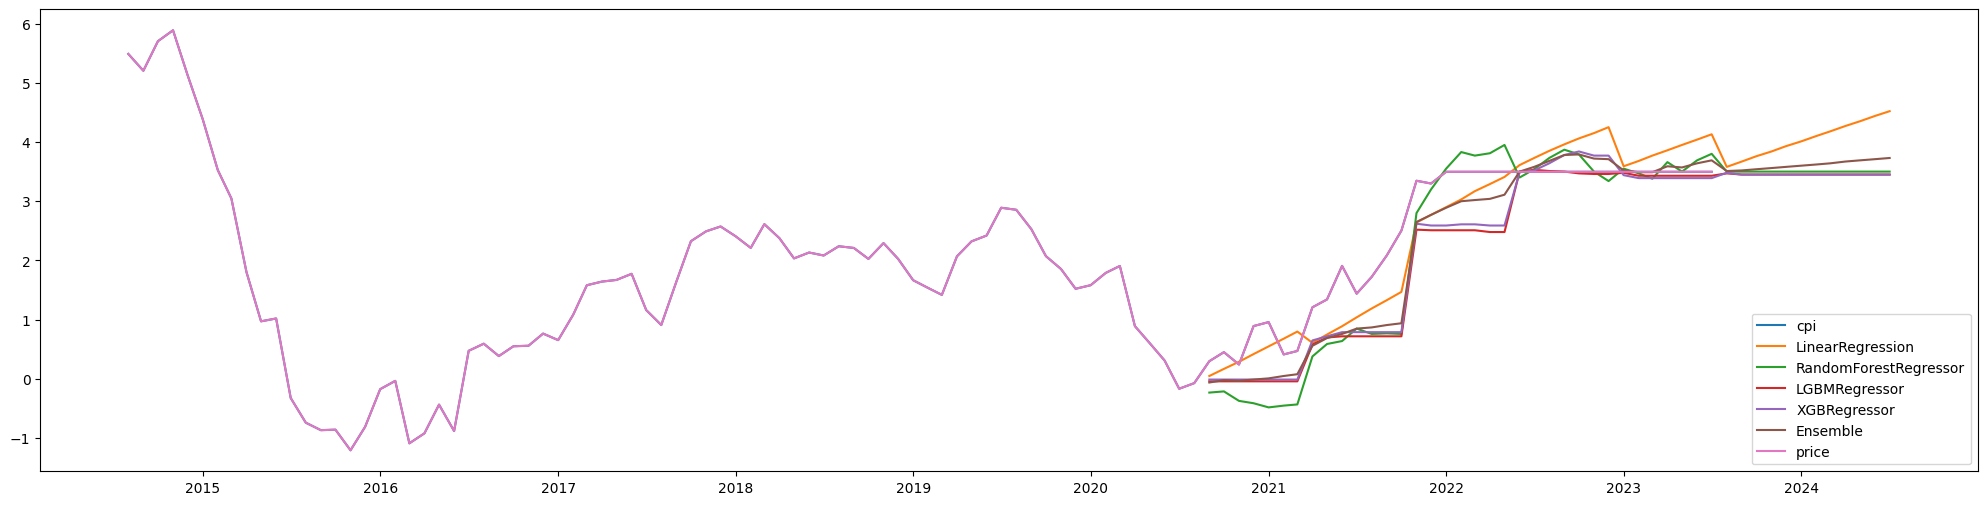

In [263]:
# Filter the chart by country for Best Model
chart_data_filtered = chart_data[chart_data.index.get_level_values(0)==country].droplevel(0)

# Set figure size to wider
plt.figure(figsize=(25,6))
for col in chart_data_filtered.columns:
    plt.plot(chart_data_filtered.index, chart_data_filtered[col], label=col)
    
plt.legend()

Analysis: Seems like the Best Model by MAE (Linear Regression) is predicting that for the country CRI (Costa Rica), the CPI is projected to increase steadily for the next 6 months.

# Visualisation with specific user selection

The best model for the USA (by MSE) is LinearRegression with MSE: 2.6822138390066286
The best model for the USA (by MAPE) is LinearRegression with MAPE: 0.2700115686083475
The best model for the USA (by MAE) is LinearRegression with MAE: 1.2901169714285714


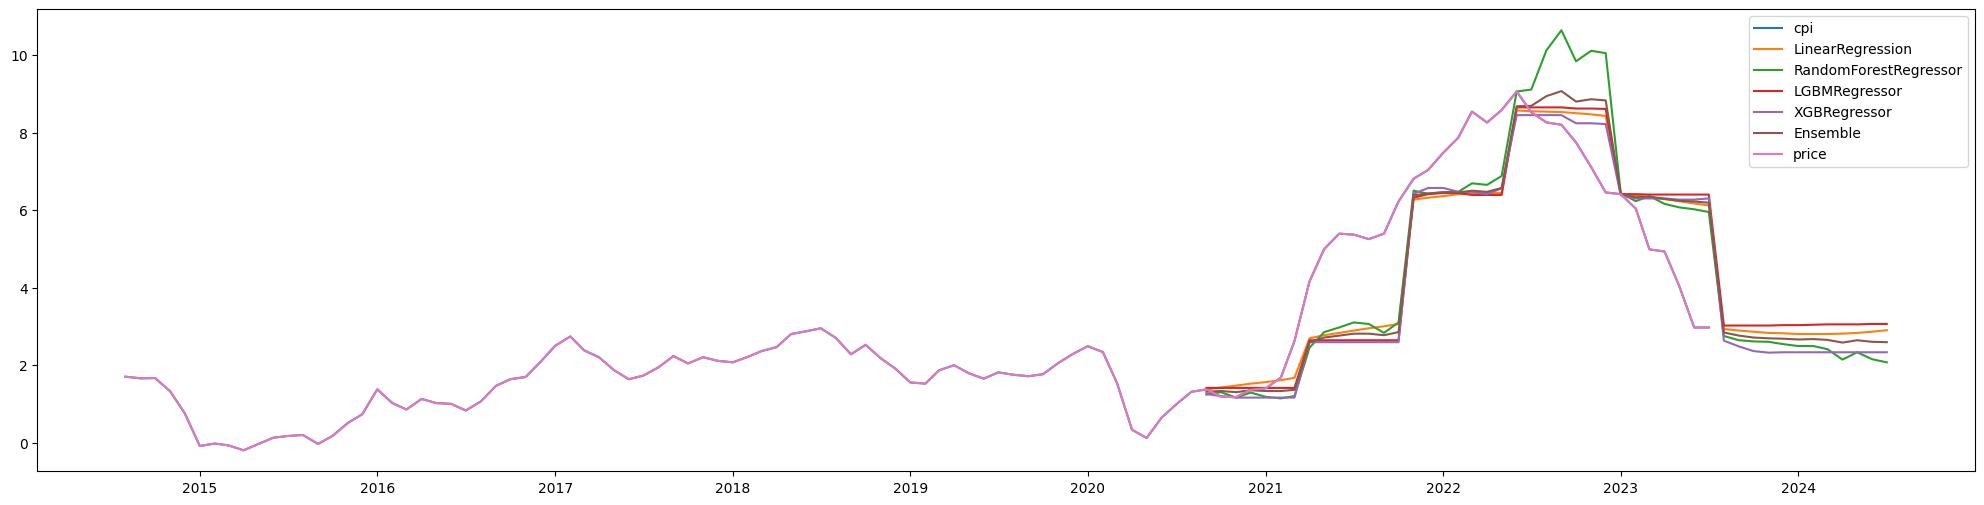

In [299]:
# Visualize user selected commodity
country = input("Please enter country code (e.g. USA, CHN):")
country_best_model_by_mape = rank_by_mape[rank_by_mape["country"]==country]
country_best_model_by_mse = rank_by_mse[rank_by_mse["country"]==country]
country_best_model_by_mae = rank_by_mae[rank_by_mae["country"]==country]

best_model_by_mape = country_best_model_by_mape.iloc[0]["model"]
best_model_by_mae = country_best_model_by_mae.iloc[0]["model"]
best_model_by_mse = country_best_model_by_mse.iloc[0]["model"]
mse = country_best_model_by_mse.iloc[0]["mse"]
mape = country_best_model_by_mape.iloc[0]["mape"]
mae = country_best_model_by_mae.iloc[0]["mae"]

print(f"The best model for the {country} (by MSE) is {best_model_by_mse} with MSE: {mse}")
print(f"The best model for the {country} (by MAPE) is {best_model_by_mape} with MAPE: {mape}")
print(f"The best model for the {country} (by MAE) is {best_model_by_mae} with MAE: {mae}")

chart_data_filtered = chart_data[chart_data.index.get_level_values(0)==country].droplevel(0)

# Set figure size to wider
plt.figure(figsize=(25,6))
for col in chart_data_filtered.columns:
    plt.plot(chart_data_filtered.index, chart_data_filtered[col], label=col)
    
plt.legend()